# Projeto de Simulação - Algotrading
### Vinícius Matheus Morales
___
## Introdução
O estudo realizado nesse projeto tem como tema mesclar três indicadores técnicos para a tomada de decisão de compra ou venda de um determinado ativo.
___

## Metodologia
Os indicadores que serão utilizados para tal serão:
- Bollinger Bands https://en.wikipedia.org/wiki/Bollinger_Bands
- KST Oscillator https://en.wikipedia.org/wiki/KST_oscillator
- Parabolic SAR https://en.wikipedia.org/wiki/Parabolic_SAR

### Bollinger Bands
Calcula-se um range em torno da média móvel com base em uma quantidade *m* de desvios padrão da média de um período *n*.

$$ Upper band = avg(p, n) + m * std(p, n) $$
$$ Lower band = avg(p, n) - m * std(p, n) $$

Pode ser interpretado de diversas maneiras, tais como:
1. Comprar quando o preço tocar a banda inferior e vender quando tocar a banda superior.
2. Comprar quando o preço tocar a banda superior e vender quando tocar a banda inferior.
3. Comprar quando o preço tocar a banda inferior e zerar posição quando tocar a média móvel.
4. Utilizar um *m* baixo e um *n* rápido para atuar como *trend follower*.
5. etc.

Nesse projeto será usado como *trend follower*
___
### Know Sure Thing Oscillator (KST)
Esse indicador será usado como oscilador no projeto.

Primeiro calcula-se quatro taxas de variação suavizadas com tendo como base *X1*, *X2*, *X3* e *X4* dias, semanas ou meses anteriores.
$$ ROC1 = (Price/Price(X1) - 1) * 100 $$
$$ ROC2 = (Price/Price(X2) - 1) * 100 $$
$$ ROC3 = (Price/Price(X3) - 1) * 100 $$
$$ ROC4 = (Price/Price(X4) - 1) * 100 $$

Sendo *X1*, *X2*, *X3* e *X4* iguais à, respectivamente:
- 10, 15, 20, 30 (dias)
- 10, 13, 15, 20 (semanas)
- 9, 12, 18, 24 (meses)

Então suaviza as taxas de variação, respectivamente, seguindo padrões recomendados por Martin J Pring (criador do indicador) com base em médias móveis simples, nomeadas de *AVG1*, *AVG2*, *AVG3* e *AVG4*, com valores:
- 10, 10, 10, 15 (dias)
- 10, 13, 15, 20 (semanas)
- 6, 6, 6, 9 (meses)

Tendo também, como padrão, os pesos *W1*, *W2*, *W3* e *W4*, respectivamente:
$$ W1 = 1 $$
$$ W2 = 2 $$
$$ W3 = 3 $$
$$ W4 = 4 $$

Ficando então como fórmula final:
$$ KST = MOV(ROC1, AVG1) * W1 + MOV(ROC2, AVG2) * W2 + MOV(ROC3, AVG3) * W3 + MOV(ROC4, AVG4) * W4 $$

Sendo que MOV(ROC, AVG) é a média móvel simples do período *AVG* de taxa de variação *ROC*

Por fim, se compara os cruzamentos com a média móvel simples de 9 dias, semanas ou meses.

A tomada de decisão se baseia em:
1. Comprar quando KST cruzar vindo por baixo da média móvel de 9 dias, semanas ou meses.
2. Vender quando KST cruzar vindo por cima da média móvel de 9 dias, semanas ou meses.
___
### Parabolic Stop And Reverse (PSAR)
Esse indicador é excelente para ser usado como stop loss ou stop gain, será com essa funcionalidade que ele será usado no projeto.

O cálculo dele é feito da seguinte forma:
$$ SAR(amanhã) = SAR(hoje) + AF(EP - SAR(hoje)) $$

Sendo AF e EP, respectivamente, Acceleration Factor e Extreme Point, ou seja, fator de aceleração e ponto extremo.

Porém existem dois casos, o PSAR em alta e o PSAR em queda, sendo diferenciado na equação como:

PSAR em alta: $$ SAR(amanhã) = SAR(hoje) + AF(EP - SAR(hoje)) $$

PSAR em queda: $$ SAR(amanhã) = SAR(hoje) - AF(EP - SAR(hoje)) $$
___
## Resultado esperado
Será utilizada a seguinte fórmula para determinar qual caminho seguir:
$$ signal = bb + 2*(kst + psar) $$

Ou seja, se o KST e o PSAR discordarem entre si, o mercado será considerado em tendência e a decisão será do Bollinger Bands.

Já se eles concordarem, o mercado será considerado oscilatório e a decisão será tomada por eles.

Vale ressaltar que as posições que podem ser tomadas são:
- 1 para entrar comprado
- -1 para entrar vendido
- 0 para não ter posição no momento

E também que:
$$ signal = 1 , signal > 0 $$
$$ signal = -1 , signal < 0 $$
$$ signal = 0 , signal = 0 $$

Tendo então como conjunto:
$$ S = [-1, 1] | S∈Z $$

O *stop gain* e *stop loss* para o mercado em tendência será o próprio Bollinger Bands, enquanto para o mercado oscilatório será o PSAR.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import time, datetime, random
from dateutil.relativedelta import relativedelta

# Para fazer o backtesting
from backtesting import evaluateHist, evaluateIntr, Strategy, Order

In [2]:
# O scrape desses dados não estava dando certo
tickers = 'AMD AMC AAPL NIO DIDI PATH BAC ITUB NVDA F TLRY CCL INTC T TELL SWN MU MSFT SOFI OXY DNA AAL VZ PBR BABA PBR VALE IQ C XOM CSCO HOOD PFE ET BBD KMI FB HPQ BCS ABEV NLY WBA PLTR CMCSA KOS NCLH TME UBER FLEX MRO PLUG PDD NOK SIRI PBCT JPM GM BMY GRAB KO RIG NLSN TSLA BEKE FCEL LCID KGC PBR-A SNAP LAC NAVI DKNG CLF RLX PYPL JD RBLX M SQ SPCE BP QCOM UMC CX CCJ TSM VTRS HST SCHW RIVN AUY MRK DIS AFRM BB X CSX UAL ZNGA SLB GOLD JNJ DVN SBUX TWTR CVE VIPS HD NKLA RF BKR FCX V BILI IBN HBAN HPE CVX TJX TEVA LU BSX NEE PINS CHPT PLAN DAL FUTU COP PTON OPEN USB FTI CDEV ORCL AGNC EBAY UPST XPEV HAL STNE CTRA WMT WMB KEY BTG GME GGB LUMN CS ABBV PCG DISCA CVS KR AMAT COTY MS EQT LI ING MDLZ IVZ GILD GE MARA QS AR MRVL SHO GPS MOS BIDU APA CHWY INFY TPX DHI CL AMCR FITB CPG PG ARVI TFC CNHI CGC FHN LYG LOW JBLU MNDT PARA NKE TXN CRM NEM MPC MO MDT NRZ BTU RRC ERIC SU Z CNP MTTR DELL BA SMFG NYCB HL SID RYCEY ON EXC GFI AZN BBWI ASX BRK-B PEP RIOT FRGE PPL MQ SE BK WE VICI SYF UAA AEO SO MRNA JNPR VRT RTX EQNR IS KIM RCL ABT CPNG VLO SABR SLM CG SLM CIG TECK GLW PAA KHC EPD'
tickers = tickers.split() # Transformando em lista
tickers = list(set(tickers)) # Removendo duplicados

# Escolher aleatoriamente 3 tickers
ticker1 = random.choice(tickers)
tickers.remove(ticker1)

ticker2 = random.choice(tickers)
tickers.remove(ticker2)

ticker3 = random.choice(tickers)
tickers.remove(ticker3)

sel_tickers = [ticker1, ticker2, ticker3]

print(f'Os tickers escolhidos foram: {ticker1}, {ticker2} e {ticker3}')

Os tickers escolhidos foram: CVX, MRO e MOS


In [3]:
# Bloco para gerar um dia útil aleatório entre 5 a 10 anos atrás

# Função para conferir se o dia dado é útil
is_bday = lambda date: bool(len(pd.bdate_range(date, date)))

# Dia útil mais próximo de hoje
today = datetime.date.today()
while not is_bday(today):
    today -= datetime.timedelta(days=1)

# Enquanto não for um dia útil, gerar novamente um ano aleatório
start_date = today - relativedelta(years=random.choice([5, 6, 7, 8, 9, 10]))
while not is_bday(start_date):
    start_date -= datetime.timedelta(days=1)
    
print(f'O dia útil no qual iniciará o teste é: {start_date.strftime("%d/%m/%Y")}')
print(f'O dia útil mais próximo de hoje é: {today.strftime("%d/%m/%Y")}')

today = str(today)
start_date = str(start_date)

O dia útil no qual iniciará o teste é: 08/04/2013
O dia útil mais próximo de hoje é: 08/04/2022


In [4]:
import yahoofinancials as yf
for ticker in sel_tickers:
    data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, today, 'daily')

    # Ler os dados do JSON
    raw = pd.DataFrame(data[ticker]['prices']).dropna()
    # Converter a data para o tipo correto datetime
    raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
    # Indica a data como o índice de cada linha
    raw = raw.set_index('formatted_date')
    # Removendo as colunas que não interessam
    df = raw.iloc[:,1:]

    # Acertando a ordem das colunas
    df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
    # Salvando o CSV
    df.to_csv(f'{ticker}.csv')

In [5]:
df1 = pd.read_csv(f'{ticker1}.csv')
df1.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2013-04-08,117.449997,117.870003,116.650002,117.809998,80.496223,4117400
1,2013-04-09,117.989998,118.870003,117.629997,118.639999,81.063347,4849700
2,2013-04-10,118.889999,119.830002,118.510002,119.639999,81.746620,5452000
3,2013-04-11,119.959999,121.150002,119.519997,120.949997,82.641716,6092300
4,2013-04-12,120.459999,120.900002,119.500000,119.940002,81.951630,6391700


In [6]:
df2 = pd.read_csv(f'{ticker2}.csv')
df2.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2013-04-08,32.500000,32.939999,32.419998,32.840000,28.155495,3224800
1,2013-04-09,32.970001,33.599998,32.810001,33.470001,28.695633,3180200
2,2013-04-10,33.540001,33.990002,33.480000,33.910000,29.072863,4784800
3,2013-04-11,33.980000,34.119999,33.740002,33.799999,28.978563,4023000
4,2013-04-12,33.500000,33.570000,32.250000,32.540001,27.898289,6103000


In [7]:
df3 = pd.read_csv(f'{ticker3}.csv')
df3.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2013-04-08,59.200001,59.320000,58.599998,58.919998,50.171288,1477700
1,2013-04-09,59.139999,60.369999,59.139999,59.950001,51.048355,2341300
2,2013-04-10,60.060001,60.599998,59.660000,60.080002,51.159039,2731800
3,2013-04-11,60.080002,60.730000,59.970001,60.610001,51.610352,1869100
4,2013-04-12,60.419998,60.480000,58.799999,59.200001,50.409706,2521700


In [8]:
help(ta.bbands)

Help on function bbands in module pandas_ta.volatility.bbands:

bbands(close, length=None, std=None, ddof=0, mamode=None, talib=None, offset=None, **kwargs)
    Bollinger Bands (BBANDS)
    
    A popular volatility indicator by John Bollinger.
    
    Sources:
        https://www.tradingview.com/wiki/Bollinger_Bands_(BB)
    
    Calculation:
        Default Inputs:
            length=5, std=2, mamode="sma", ddof=0
        EMA = Exponential Moving Average
        SMA = Simple Moving Average
        STDEV = Standard Deviation
        stdev = STDEV(close, length, ddof)
        if "ema":
            MID = EMA(close, length)
        else:
            MID = SMA(close, length)
    
        LOWER = MID - std * stdev
        UPPER = MID + std * stdev
    
        BANDWIDTH = 100 * (UPPER - LOWER) / MID
        PERCENT = (close - LOWER) / (UPPER - LOWER)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): The short period. Default: 5
        std (int): The long 

In [9]:
class Bollinger(Strategy):

    def __init__(self):
        
        # Quantidade de dias de cada média móvel
        self.period = 9
        
        # Número de desvios da banda
        self.m = 1.9
        
        # Lista para guardar os preços e o indicador
        self.prices = []
        self.indicator = []
    
        # Side da estratégia (+1 Compra/-1 Vende)
        self.signals = []
        self.side = 0


    def push(self, event):
        
        orders = []

        price = event.price[3] # Captura o preço atual vindo do evento
        
        # Montando a série de preços:
        self.prices.append(price)
        
        # Se a quantidade de preços observados for superior a janela
        # Só começa a contar a estratégia a partir do dia indicado pelo período
        if len(self.prices) > self.period:
            
            # Monta a lista de preços em um dataframe
            close = pd.DataFrame({'close': self.prices})
            
            bbands = close.ta.bbands(lenght=self.period, std=self.m, offset=self.period//2)
            
            down = bbands.iloc[-1, 0]
            avg  = bbands.iloc[-1, 1]
            up   = bbands.iloc[-1, 2]
            
            # Guarda os dados para o gráfico
            self.indicator.append([up, avg, down])
            
            # Se o preço estiver abaixo da banda inferior compra, senão vende
            if price < down:
                signal = 1 
            elif price > up:
                signal = -1
            elif price > avg and self.side == -1:
                signal = 0
            elif price < avg and self.side == 1:
                signal = 0
            else:
                signal = self.side
            
            # Ajustando a posição
            if self.side != signal:
                orders.append(Order(event.instrument, -self.side, 0))
                orders.append(Order(event.instrument, signal, 0))
                self.side = signal
        
        try:
            self.signals.append(signal)
        except:
            self.signals.append(0)
            
        return orders

In [10]:
modelBollinger = Bollinger()
print(evaluateHist(modelBollinger, {ticker1: f'{ticker1}.csv'}))

Number of trades: 314
Gross P&L: 11.05
Gross Accumulated return: 0.04%
Gross Average Return: 0.10%
Net P&L: 11.01
Hitting ratio: 64.65%



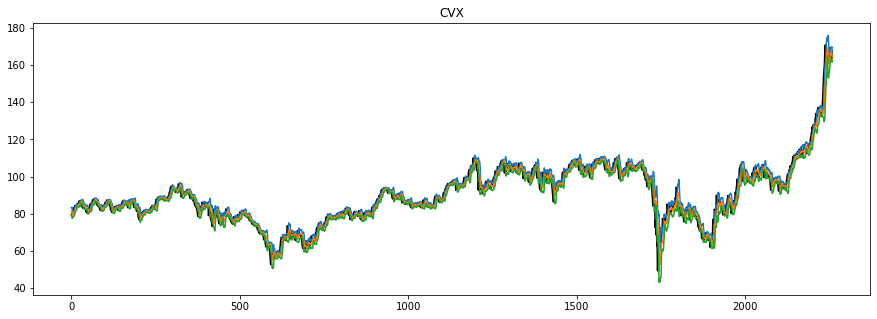

In [11]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker1)
ax.plot(modelBollinger.prices[-len(modelBollinger.indicator):], color='black');
ax.plot(modelBollinger.indicator);

In [12]:
modelBollinger = Bollinger()
print(evaluateHist(modelBollinger, {ticker2: f'{ticker2}.csv'}))

Number of trades: 328
Gross P&L: 3.58
Gross Accumulated return: 0.06%
Gross Average Return: -0.12%
Net P&L: 3.57
Hitting ratio: 66.16%



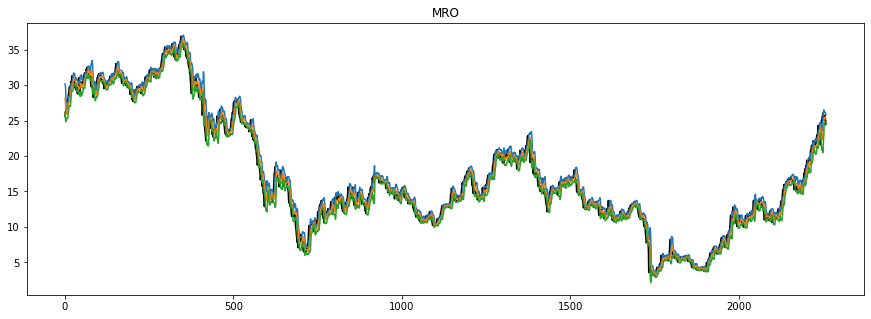

In [13]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker2)
ax.plot(modelBollinger.prices[-len(modelBollinger.indicator):], color='black');
ax.plot(modelBollinger.indicator);

In [14]:
modelBollinger = Bollinger()
print(evaluateHist(modelBollinger, {ticker3: f'{ticker3}.csv'}))

Number of trades: 309
Gross P&L: -41.28
Gross Accumulated return: -0.44%
Gross Average Return: -0.34%
Net P&L: -41.30
Hitting ratio: 60.52%



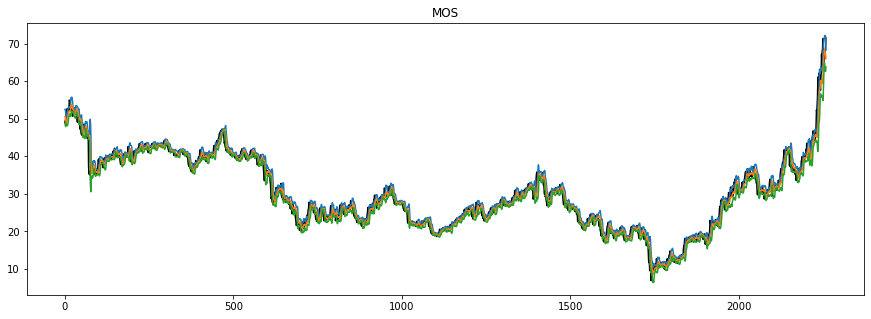

In [15]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker3)
ax.plot(modelBollinger.prices[-len(modelBollinger.indicator):], color='black');
ax.plot(modelBollinger.indicator);

In [16]:
help(ta.kst)

Help on function kst in module pandas_ta.momentum.kst:

kst(close, roc1=None, roc2=None, roc3=None, roc4=None, sma1=None, sma2=None, sma3=None, sma4=None, signal=None, drift=None, offset=None, **kwargs)
    'Know Sure Thing' (KST)
    
    The 'Know Sure Thing' is a momentum based oscillator and based on ROC.
    
    Sources:
        https://www.tradingview.com/wiki/Know_Sure_Thing_(KST)
        https://www.incrediblecharts.com/indicators/kst.php
    
    Calculation:
        Default Inputs:
            roc1=10, roc2=15, roc3=20, roc4=30,
            sma1=10, sma2=10, sma3=10, sma4=15, signal=9, drift=1
        ROC = Rate of Change
        SMA = Simple Moving Average
        rocsma1 = SMA(ROC(close, roc1), sma1)
        rocsma2 = SMA(ROC(close, roc2), sma2)
        rocsma3 = SMA(ROC(close, roc3), sma3)
        rocsma4 = SMA(ROC(close, roc4), sma4)
    
        KST = 100 * (rocsma1 + 2 * rocsma2 + 3 * rocsma3 + 4 * rocsma4)
        KST_Signal = SMA(KST, signal)
    
    Args:
        c

In [17]:
class KST(Strategy):
    
    def __init__(self):
        
        # Definir as quantidades de dias para cada taxa de variação
        self.x1 = 10 # Dias
        self.x2 = 15 # Dias
        self.x3 = 20 # Dias
        self.x4 = 30 # Dias
        
        # Definir cada intervalo de dias para as médias móveis simples
        self.avg1 = 10 # Dias
        self.avg2 = 10 # Dias
        self.avg3 = 10 # Dias
        self.avg4 = 15 # Dias
        
        # Período de 9 meses para calcular a média móvel simples de comparação
        self.period = 9 # Dias
        
        # Lista para guardar os preços e o indicador
        self.prices = []
        self.indicator = []
        
        # Side da estratégia (+1 Compra/-1 Vende)
        self.signals = []
        self.side = 0
        
    def push(self, event):
        
        orders = []
        
        price = event.price[3] # Captura o preço atual vindo do evento
        
        self.prices.append(price)
        
        if len(self.prices) > max(self.x1, self.x2, self.x3, self.x4,
                                  self.avg1, self.avg2, self.avg3, self.avg4,
                                  self.period):
            
            close = pd.DataFrame({'close': self.prices})
            
            kstdf = close.ta.kst(roc1=self.x1, roc2=self.x2, roc3=self.x3, roc4=self.x4,
                               sma1=self.avg1, sma2=self.avg2, sma3=self.avg3, sma4=self.avg4,
                               signal=self.period)
            
            kst        = kstdf.iloc[-1, 0]
            kst_before = kstdf.iloc[-2, 0]
            kst_signal = kstdf.iloc[-1, 1]
            
            # Guarda os dados para o gráfico
            self.indicator.append([kst, kst_signal])
            
            if kst_before < kst_signal:
                signal = 1
            elif kst_before > kst_signal:
                signal = -1
            else:
                signal = self.side
                
            # Ajustando posição
            if self.side != signal:
                orders.append(Order(event.instrument, -self.side, 0))
                orders.append(Order(event.instrument, signal, 0))
                self.side = signal
                
        try:
            self.signals.append(signal)
        except:
            self.signals.append(0)
            
        return orders

In [18]:
modelKST = KST()
print(evaluateHist(modelKST, {ticker1: f'{ticker1}.csv'}))

Number of trades: 135
Gross P&L: -27.28
Gross Accumulated return: -0.22%
Gross Average Return: -0.28%
Net P&L: -27.32
Hitting ratio: 56.30%



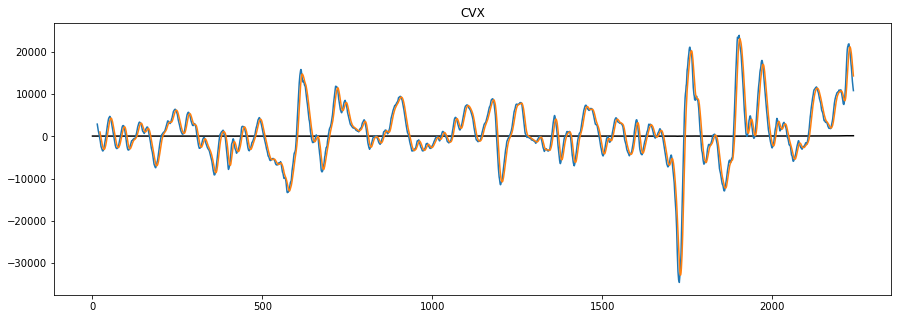

In [19]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker1)
ax.plot(modelKST.prices[-len(modelKST.indicator):], color='black');
ax.plot(modelKST.indicator);

In [20]:
modelKST = KST()
print(evaluateHist(modelKST, {ticker2: f'{ticker2}.csv'}))

Number of trades: 128
Gross P&L: -32.69
Gross Accumulated return: -1.49%
Gross Average Return: -1.90%
Net P&L: -32.70
Hitting ratio: 54.69%



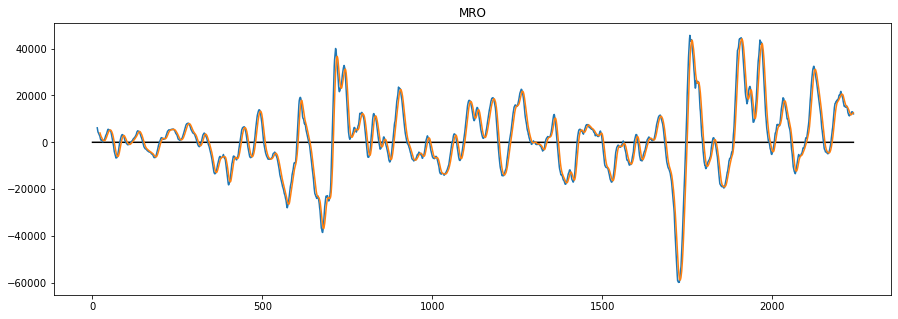

In [21]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker2)
ax.plot(modelKST.prices[-len(modelKST.indicator):], color='black');
ax.plot(modelKST.indicator);

In [22]:
modelKST = KST()
print(evaluateHist(modelKST, {ticker3: f'{ticker3}.csv'}))

Number of trades: 141
Gross P&L: -10.29
Gross Accumulated return: -0.24%
Gross Average Return: -0.53%
Net P&L: -10.31
Hitting ratio: 53.90%



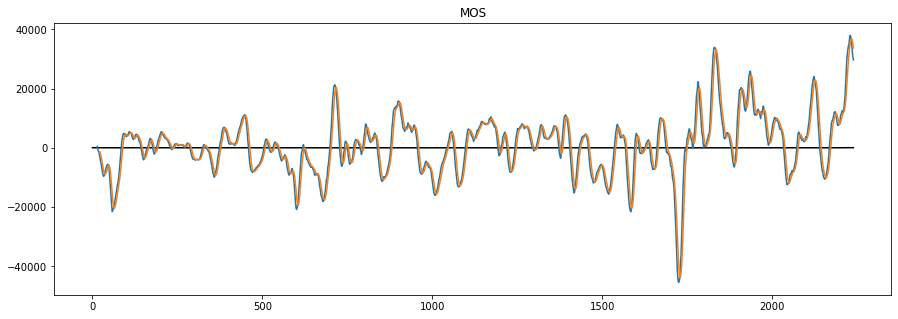

In [23]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker3)
ax.plot(modelKST.prices[-len(modelKST.indicator):], color='black');
ax.plot(modelKST.indicator);

In [24]:
help(ta.psar)

Help on function psar in module pandas_ta.trend.psar:

psar(high, low, close=None, af0=None, af=None, max_af=None, offset=None, **kwargs)
    Parabolic Stop and Reverse (psar)
    
    Parabolic Stop and Reverse (PSAR) was developed by J. Wells Wilder, that is used
    to determine trend direction and it's potential reversals in price. PSAR uses a
    trailing stop and reverse method called "SAR," or stop and reverse, to identify
    possible entries and exits. It is also known as SAR.
    
    PSAR indicator typically appears on a chart as a series of dots, either above or
    below an asset's price, depending on the direction the price is moving. A dot is
    placed below the price when it is trending upward, and above the price when it
    is trending downward.
    
    Sources:
        https://www.tradingview.com/pine-script-reference/#fun_sar
        https://www.sierrachart.com/index.php?page=doc/StudiesReference.php&ID=66&Name=Parabolic
    
    Calculation:
        Default Input

In [36]:
class PSAR(Strategy):
    
    def __init__(self):
        
        self.acc = 0.01 # Aceleração recomendada para ações = 0.01
        self.max_acc = 0.2 # Aceleração máxima recomendada = 0.2
        
        # Lista para guardar os preços high, low e close e o indicador
        # self.opens  = []
        self.highs  = []
        self.lows   = []
        self.prices = []
        
        self.indicator = []
        
        # Side da estratégia (+1 Compra/-1 Vende)
        self.signals = []
        self.side = 0
        
    def push(self, event):
        
        orders = []
        
        price = event.price[0] # Open
        high  = event.price[1] # High
        low   = event.price[2] # Low
        # price = event.price[3] # AdjClose
        
        self.highs.append(high)
        self.lows.append(low)
        self.prices.append(price)
        
        if len(self.prices) + len(self.highs) + len(self.lows) > 3:
            
            high = pd.Series(self.highs)
            low  = pd.Series(self.lows)
            open_ = pd.DataFrame({'open': self.prices})
            # close = pd.DataFrame({'close': self.prices})
            
            psardf = open_.ta.psar(high=high, low=low, af=self.acc, af0=self.acc, max_af=self.max_acc)
            
            long = psardf.iloc[-1, 0]
            short = psardf.iloc[-1, 1]
            reversal = psardf.iloc[-1, 3]
            
            # Guarda os dados para o gráfico
            self.indicator.append([long, short])
            
            if reversal == 1:
                if np.isnan(long):
                    signal = 1
                elif np.isnan(short):
                    signal = -1
                else:
                    signal = self.side
            else:
                signal = self.side
            
            # Ajustando posição
            if self.side != signal:
                orders.append(Order(event.instrument, -self.side, 0))
                orders.append(Order(event.instrument, signal, 0))
                self.side = signal
                
        try:
            self.signals.append(signal)
        except:
            self.signals.append(0)
            
        return orders

In [26]:
modelPSAR = PSAR()
print(evaluateHist(modelPSAR, {ticker1: f'{ticker1}.csv'}))

Number of trades: 133
Gross P&L: -28.19
Gross Accumulated return: -0.23%
Gross Average Return: -0.25%
Net P&L: -28.23
Hitting ratio: 58.65%



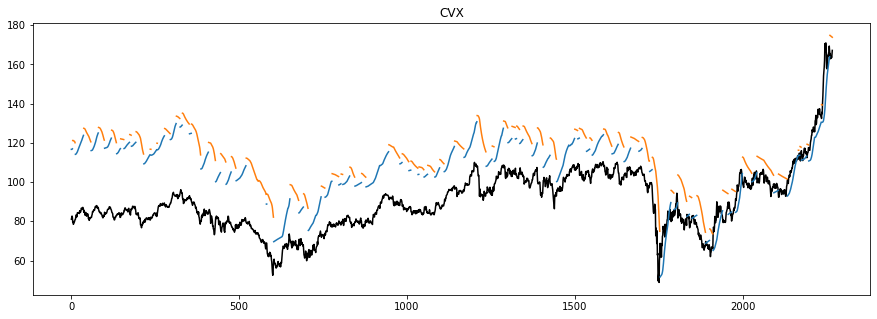

In [27]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker1)
ax.plot(modelPSAR.prices[-len(modelPSAR.indicator):], color='black');
ax.plot(modelPSAR.indicator);

In [28]:
modelPSAR = PSAR()
print(evaluateHist(modelPSAR, {ticker2: f'{ticker2}.csv'}))

Number of trades: 130
Gross P&L: -21.57
Gross Accumulated return: -0.95%
Gross Average Return: -1.37%
Net P&L: -21.58
Hitting ratio: 60.77%



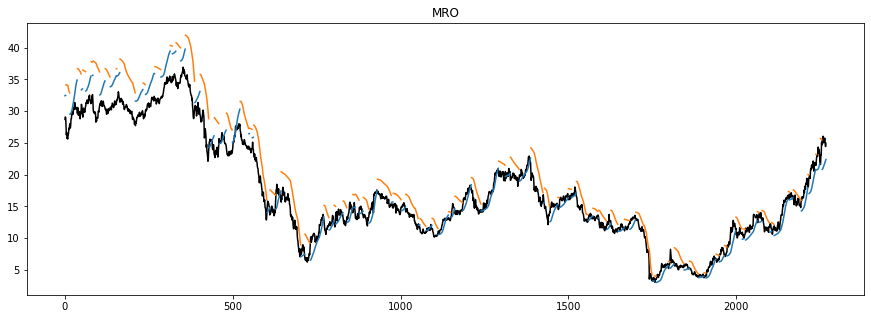

In [29]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker2)
ax.plot(modelPSAR.prices[-len(modelPSAR.indicator):], color='black');
ax.plot(modelPSAR.indicator);

In [32]:
modelPSAR = PSAR()
print(evaluateHist(modelPSAR, {ticker3: f'{ticker3}.csv'}))

high = 59.31999969482422
low = 58.599998474121094
adclose = 50.171287536621094
teste = (59.20000076293945, 59.31999969482422, 58.599998474121094, 50.171287536621094)
high = 60.369998931884766
low = 59.13999938964844
adclose = 51.04835510253906
teste = (59.13999938964844, 60.369998931884766, 59.13999938964844, 51.04835510253906)
high = 60.599998474121094
low = 59.65999984741211
adclose = 51.15903854370117
teste = (60.060001373291016, 60.599998474121094, 59.65999984741211, 51.15903854370117)
high = 60.72999954223633
low = 59.970001220703125
adclose = 51.6103515625
teste = (60.08000183105469, 60.72999954223633, 59.970001220703125, 51.6103515625)
high = 60.47999954223633
low = 58.79999923706055
adclose = 50.409706115722656
teste = (60.41999816894531, 60.47999954223633, 58.79999923706055, 50.409706115722656)
high = 58.63999938964844
low = 57.0099983215332
adclose = 48.715187072753906
teste = (58.619998931884766, 58.63999938964844, 57.0099983215332, 48.715187072753906)
high = 58.119998931884

high = 56.77000045776367
low = 55.25
adclose = 47.53642654418945
teste = (56.29999923706055, 56.77000045776367, 55.25, 47.53642654418945)
high = 56.970001220703125
low = 56.22999954223633
adclose = 48.60514831542969
teste = (56.400001525878906, 56.970001220703125, 56.22999954223633, 48.60514831542969)
high = 56.81999969482422
low = 55.93000030517578
adclose = 47.96391677856445
teste = (56.79999923706055, 56.81999969482422, 55.93000030517578, 47.96391677856445)
high = 56.18000030517578
low = 55.380001068115234
adclose = 47.98957061767578
teste = (55.689998626708984, 56.18000030517578, 55.380001068115234, 47.98957061767578)
high = 56.18000030517578
low = 53.90999984741211
adclose = 46.27107620239258
teste = (56.18000030517578, 56.18000030517578, 53.90999984741211, 46.27107620239258)
high = 54.58000183105469
low = 54.04999923706055
adclose = 46.399314880371094
teste = (54.380001068115234, 54.58000183105469, 54.04999923706055, 46.399314880371094)
high = 54.45000076293945
low = 53.930000305

high = 43.61000061035156
low = 42.869998931884766
adclose = 36.95451354980469
teste = (43.040000915527344, 43.61000061035156, 42.869998931884766, 36.95451354980469)
high = 44.0
low = 42.7599983215332
adclose = 37.787750244140625
teste = (42.939998626708984, 44.0, 42.7599983215332, 37.787750244140625)
high = 45.720001220703125
low = 43.209999084472656
adclose = 39.170738220214844
teste = (43.68000030517578, 45.720001220703125, 43.209999084472656, 39.170738220214844)
high = 45.91999816894531
low = 44.83000183105469
adclose = 38.8958625793457
teste = (45.58000183105469, 45.91999816894531, 44.83000183105469, 38.8958625793457)
high = 46.220001220703125
low = 44.88999938964844
adclose = 39.60024642944336
teste = (45.0, 46.220001220703125, 44.88999938964844, 39.60024642944336)
high = 46.47999954223633
low = 45.5
adclose = 39.20510482788086
teste = (45.779998779296875, 46.47999954223633, 45.5, 39.20510482788086)
high = 45.939998626708984
low = 45.18000030517578
adclose = 39.0161247253418
teste

high = 44.7400016784668
low = 44.20000076293945
adclose = 38.44549560546875
teste = (44.380001068115234, 44.7400016784668, 44.20000076293945, 38.44549560546875)
high = 44.79999923706055
low = 43.88999938964844
adclose = 38.67000961303711
teste = (44.47999954223633, 44.79999923706055, 43.88999938964844, 38.67000961303711)
high = 44.7400016784668
low = 44.380001068115234
adclose = 38.58366012573242
teste = (44.5099983215332, 44.7400016784668, 44.380001068115234, 38.58366012573242)
high = 45.900001525878906
low = 44.5
adclose = 39.48175811767578
teste = (44.56999969482422, 45.900001525878906, 44.5, 39.48175811767578)
high = 46.529998779296875
low = 45.58000183105469
adclose = 40.155330657958984
teste = (45.86000061035156, 46.529998779296875, 45.58000183105469, 40.155330657958984)
high = 46.810001373291016
low = 46.45000076293945
adclose = 40.31940460205078
teste = (46.4900016784668, 46.810001373291016, 46.45000076293945, 40.31940460205078)
high = 47.099998474121094
low = 46.70000076293945

high = 49.2400016784668
low = 48.689998626708984
adclose = 42.50527572631836
teste = (49.099998474121094, 49.2400016784668, 48.689998626708984, 42.50527572631836)
high = 50.25
low = 48.619998931884766
adclose = 43.26909255981445
teste = (48.9900016784668, 50.25, 48.619998931884766, 43.26909255981445)
high = 50.630001068115234
low = 49.91999816894531
adclose = 43.399295806884766
teste = (50.11000061035156, 50.630001068115234, 49.91999816894531, 43.399295806884766)
high = 50.16999816894531
low = 49.47999954223633
adclose = 43.164939880371094
teste = (49.90999984741211, 50.16999816894531, 49.47999954223633, 43.164939880371094)
high = 49.939998626708984
low = 49.060001373291016
adclose = 43.303810119628906
teste = (49.709999084472656, 49.939998626708984, 49.060001373291016, 43.303810119628906)
high = 49.939998626708984
low = 48.459999084472656
adclose = 42.366390228271484
teste = (49.939998626708984, 49.939998626708984, 48.459999084472656, 42.366390228271484)
high = 48.7599983215332
low = 

high = 49.720001220703125
low = 49.13999938964844
adclose = 42.965301513671875
teste = (49.220001220703125, 49.720001220703125, 49.13999938964844, 42.965301513671875)
high = 49.959999084472656
low = 49.34000015258789
adclose = 43.12153625488281
teste = (49.34000015258789, 49.959999084472656, 49.34000015258789, 43.12153625488281)
high = 50.029998779296875
low = 49.349998474121094
adclose = 43.399295806884766
teste = (49.619998931884766, 50.029998779296875, 49.349998474121094, 43.399295806884766)
high = 50.029998779296875
low = 49.38999938964844
adclose = 42.94794464111328
teste = (49.689998626708984, 50.029998779296875, 49.38999938964844, 42.94794464111328)
high = 49.650001525878906
low = 49.20000076293945
adclose = 42.991336822509766
teste = (49.560001373291016, 49.650001525878906, 49.20000076293945, 42.991336822509766)
high = 49.869998931884766
low = 49.400001525878906
adclose = 43.026065826416016
teste = (49.59000015258789, 49.869998931884766, 49.400001525878906, 43.026065826416016)


high = 47.029998779296875
low = 45.84000015258789
adclose = 40.94865798950195
teste = (46.16999816894531, 47.029998779296875, 45.84000015258789, 40.94865798950195)
high = 47.27000045776367
low = 46.61000061035156
adclose = 41.09695053100586
teste = (46.70000076293945, 47.27000045776367, 46.61000061035156, 41.09695053100586)
high = 47.18000030517578
low = 46.65999984741211
adclose = 41.027164459228516
teste = (46.66999816894531, 47.18000030517578, 46.65999984741211, 41.027164459228516)
high = 47.25
low = 46.06999969482422
adclose = 40.320556640625
teste = (47.150001525878906, 47.25, 46.06999969482422, 40.320556640625)
high = 46.29999923706055
low = 45.619998931884766
adclose = 40.37290573120117
teste = (46.220001220703125, 46.29999923706055, 45.619998931884766, 40.37290573120117)
high = 46.7599983215332
low = 46.40999984741211
adclose = 40.5648193359375
teste = (46.47999954223633, 46.7599983215332, 46.40999984741211, 40.5648193359375)
high = 46.65999984741211
low = 46.369998931884766
ad

high = 41.7400016784668
low = 40.56999969482422
adclose = 35.86735153198242
teste = (40.56999969482422, 41.7400016784668, 40.56999969482422, 35.86735153198242)
high = 41.4900016784668
low = 40.7599983215332
adclose = 35.74456024169922
teste = (41.16999816894531, 41.4900016784668, 40.7599983215332, 35.74456024169922)
high = 42.0
low = 40.81999969482422
adclose = 36.65660095214844
teste = (40.86000061035156, 42.0, 40.81999969482422, 36.65660095214844)
high = 42.779998779296875
low = 42.119998931884766
adclose = 37.38447570800781
teste = (42.130001068115234, 42.779998779296875, 42.119998931884766, 37.38447570800781)
high = 43.27000045776367
low = 42.72999954223633
adclose = 37.54232406616211
teste = (42.75, 43.27000045776367, 42.72999954223633, 37.54232406616211)
high = 43.2400016784668
low = 42.349998474121094
adclose = 37.21784591674805
teste = (43.15999984741211, 43.2400016784668, 42.349998474121094, 37.21784591674805)
high = 43.470001220703125
low = 42.459999084472656
adclose = 38.024

high = 46.25
low = 45.630001068115234
adclose = 40.25791549682617
teste = (46.15999984741211, 46.25, 45.630001068115234, 40.25791549682617)
high = 46.040000915527344
low = 45.40999984741211
adclose = 40.36373519897461
teste = (45.86000061035156, 46.040000915527344, 45.40999984741211, 40.36373519897461)
high = 45.689998626708984
low = 44.810001373291016
adclose = 39.64060592651367
teste = (45.40999984741211, 45.689998626708984, 44.810001373291016, 39.64060592651367)
high = 45.779998779296875
low = 44.869998931884766
adclose = 40.16972351074219
teste = (45.27000045776367, 45.779998779296875, 44.869998931884766, 40.16972351074219)
high = 46.150001525878906
low = 45.56999969482422
adclose = 40.38138198852539
teste = (45.790000915527344, 46.150001525878906, 45.56999969482422, 40.38138198852539)
high = 46.43000030517578
low = 46.02000045776367
adclose = 40.85758972167969
teste = (46.18000030517578, 46.43000030517578, 46.02000045776367, 40.85758972167969)
high = 46.58000183105469
low = 45.720

high = 47.97999954223633
low = 46.70000076293945
adclose = 42.13024139404297
teste = (47.08000183105469, 47.97999954223633, 46.70000076293945, 42.13024139404297)
high = 46.83000183105469
low = 46.16999816894531
adclose = 41.04930114746094
teste = (46.619998931884766, 46.83000183105469, 46.16999816894531, 41.04930114746094)
high = 47.0099983215332
low = 45.91999816894531
adclose = 41.19993591308594
teste = (46.540000915527344, 47.0099983215332, 45.91999816894531, 41.19993591308594)
high = 47.09000015258789
low = 46.31999969482422
adclose = 41.52775192260742
teste = (46.630001068115234, 47.09000015258789, 46.31999969482422, 41.52775192260742)
high = 47.13999938964844
low = 46.41999816894531
adclose = 41.57205581665039
teste = (46.91999816894531, 47.13999938964844, 46.41999816894531, 41.57205581665039)
high = 47.599998474121094
low = 46.4900016784668
adclose = 41.22650909423828
teste = (47.06999969482422, 47.599998474121094, 46.4900016784668, 41.22650909423828)
high = 47.290000915527344
l

high = 45.15999984741211
low = 44.529998779296875
adclose = 39.73970413208008
teste = (45.099998474121094, 45.15999984741211, 44.529998779296875, 39.73970413208008)
high = 44.619998931884766
low = 44.220001220703125
adclose = 39.4990119934082
teste = (44.349998474121094, 44.619998931884766, 44.220001220703125, 39.4990119934082)
high = 44.36000061035156
low = 44.02000045776367
adclose = 39.249412536621094
teste = (44.25, 44.36000061035156, 44.02000045776367, 39.249412536621094)
high = 44.25
low = 43.810001373291016
adclose = 39.16028594970703
teste = (44.0, 44.25, 43.810001373291016, 39.16028594970703)
high = 44.7400016784668
low = 44.09000015258789
adclose = 39.76642990112305
teste = (44.220001220703125, 44.7400016784668, 44.09000015258789, 39.76642990112305)
high = 44.959999084472656
low = 44.58000183105469
adclose = 39.980377197265625
teste = (44.61000061035156, 44.959999084472656, 44.58000183105469, 39.980377197265625)
high = 45.0
low = 44.40999984741211
adclose = 39.70404052734375


high = 43.369998931884766
low = 42.40999984741211
adclose = 37.94793701171875
teste = (43.29999923706055, 43.369998931884766, 42.40999984741211, 37.94793701171875)
high = 42.4900016784668
low = 41.47999954223633
adclose = 36.97628402709961
teste = (42.2599983215332, 42.4900016784668, 41.47999954223633, 36.97628402709961)
high = 41.33000183105469
low = 39.93000030517578
adclose = 35.603492736816406
teste = (41.22999954223633, 41.33000183105469, 39.93000030517578, 35.603492736816406)
high = 39.650001525878906
low = 37.20000076293945
adclose = 34.088069915771484
teste = (38.0, 39.650001525878906, 37.20000076293945, 34.088069915771484)
high = 39.439998626708984
low = 37.5
adclose = 33.490821838378906
teste = (39.25, 39.439998626708984, 37.5, 33.490821838378906)
high = 38.9900016784668
low = 37.97999954223633
adclose = 34.694244384765625
teste = (38.31999969482422, 38.9900016784668, 37.97999954223633, 34.694244384765625)
high = 40.709999084472656
low = 39.5
adclose = 36.14726638793945
teste

high = 34.68000030517578
low = 33.72999954223633
adclose = 30.944734573364258
teste = (33.86000061035156, 34.68000030517578, 33.72999954223633, 30.944734573364258)
high = 36.95000076293945
low = 33.2400016784668
adclose = 32.76659393310547
teste = (33.540000915527344, 36.95000076293945, 33.2400016784668, 32.76659393310547)
high = 36.529998779296875
low = 33.189998626708984
adclose = 29.957517623901367
teste = (36.52000045776367, 36.529998779296875, 33.189998626708984, 29.957517623901367)
high = 33.88999938964844
low = 32.47999954223633
adclose = 29.320308685302734
teste = (33.45000076293945, 33.88999938964844, 32.47999954223633, 29.320308685302734)
high = 32.90999984741211
low = 32.150001525878906
adclose = 29.167743682861328
teste = (32.66999816894531, 32.90999984741211, 32.150001525878906, 29.167743682861328)
high = 32.79999923706055
low = 31.700000762939453
adclose = 29.293384552001953
teste = (32.5, 32.79999923706055, 31.700000762939453, 29.293384552001953)
high = 32.7400016784668


high = 24.399999618530273
low = 22.690000534057617
adclose = 21.664735794067383
teste = (24.3799991607666, 24.399999618530273, 22.690000534057617, 21.664735794067383)
high = 24.969999313354492
low = 23.790000915527344
adclose = 22.289419174194336
teste = (24.110000610351562, 24.969999313354492, 23.790000915527344, 22.289419174194336)
high = 26.229999542236328
low = 23.3700008392334
adclose = 21.592313766479492
teste = (25.25, 26.229999542236328, 23.3700008392334, 21.592313766479492)
high = 23.219999313354492
low = 22.15999984741211
adclose = 20.279565811157227
teste = (23.219999313354492, 23.219999313354492, 22.15999984741211, 20.279565811157227)
high = 23.09000015258789
low = 22.399999618530273
adclose = 20.686967849731445
teste = (22.43000030517578, 23.09000015258789, 22.399999618530273, 20.686967849731445)
high = 23.200000762939453
low = 22.15999984741211
adclose = 20.433473587036133
teste = (22.809999465942383, 23.200000762939453, 22.15999984741211, 20.433473587036133)
high = 23.18

high = 25.799999237060547
low = 25.170000076293945
adclose = 23.207902908325195
teste = (25.600000381469727, 25.799999237060547, 25.170000076293945, 23.207902908325195)
high = 25.5
low = 24.520000457763672
adclose = 23.2353458404541
teste = (25.40999984741211, 25.5, 24.520000457763672, 23.2353458404541)
high = 25.399999618530273
low = 24.520000457763672
adclose = 22.640743255615234
teste = (25.190000534057617, 25.399999618530273, 24.520000457763672, 22.640743255615234)
high = 25.670000076293945
low = 24.8700008392334
adclose = 22.832836151123047
teste = (25.110000610351562, 25.670000076293945, 24.8700008392334, 22.832836151123047)
high = 25.149999618530273
low = 24.649999618530273
adclose = 22.750516891479492
teste = (24.959999084472656, 25.149999618530273, 24.649999618530273, 22.750516891479492)
high = 25.639999389648438
low = 24.56999969482422
adclose = 23.354267120361328
teste = (24.979999542236328, 25.639999389648438, 24.56999969482422, 23.354267120361328)
high = 26.559999465942383

high = 26.8700008392334
low = 25.93000030517578
adclose = 24.725826263427734
teste = (25.93000030517578, 26.8700008392334, 25.93000030517578, 24.725826263427734)
high = 27.729999542236328
low = 26.850000381469727
adclose = 24.855281829833984
teste = (27.06999969482422, 27.729999542236328, 26.850000381469727, 24.855281829833984)
high = 27.149999618530273
low = 26.079999923706055
adclose = 24.938505172729492
teste = (26.860000610351562, 27.149999618530273, 26.079999923706055, 24.938505172729492)
high = 27.649999618530273
low = 26.690000534057617
adclose = 24.725826263427734
teste = (27.190000534057617, 27.649999618530273, 26.690000534057617, 24.725826263427734)
high = 28.700000762939453
low = 27.549999237060547
adclose = 25.89091682434082
teste = (27.56999969482422, 28.700000762939453, 27.549999237060547, 25.89091682434082)
high = 27.829999923706055
low = 26.639999389648438
adclose = 24.883020401000977
teste = (26.93000030517578, 27.829999923706055, 26.639999389648438, 24.883020401000977

high = 30.389999389648438
low = 29.549999237060547
adclose = 27.804994583129883
teste = (30.299999237060547, 30.389999389648438, 29.549999237060547, 27.804994583129883)
high = 30.030000686645508
low = 29.040000915527344
adclose = 26.972789764404297
teste = (30.0, 30.030000686645508, 29.040000915527344, 26.972789764404297)
high = 29.850000381469727
low = 28.899999618530273
adclose = 27.268680572509766
teste = (29.479999542236328, 29.850000381469727, 28.899999618530273, 27.268680572509766)
high = 29.510000228881836
low = 28.6200008392334
adclose = 26.741321563720703
teste = (29.280000686645508, 29.510000228881836, 28.6200008392334, 26.741321563720703)
high = 29.15999984741211
low = 28.18000030517578
adclose = 26.666656494140625
teste = (28.520000457763672, 29.15999984741211, 28.18000030517578, 26.666656494140625)
high = 28.950000762939453
low = 28.100000381469727
adclose = 26.36797332763672
teste = (28.6299991607666, 28.950000762939453, 28.100000381469727, 26.36797332763672)
high = 28.12

high = 28.299999237060547
low = 27.450000762939453
adclose = 26.405311584472656
teste = (27.450000762939453, 28.299999237060547, 27.450000762939453, 26.405311584472656)
high = 28.190000534057617
low = 27.56999969482422
adclose = 26.087961196899414
teste = (28.1299991607666, 28.190000534057617, 27.56999969482422, 26.087961196899414)
high = 27.950000762939453
low = 27.149999618530273
adclose = 25.39725685119629
teste = (27.729999542236328, 27.950000762939453, 27.149999618530273, 25.39725685119629)
high = 27.440000534057617
low = 27.020000457763672
adclose = 25.509265899658203
teste = (27.239999771118164, 27.440000534057617, 27.020000457763672, 25.509265899658203)
high = 28.360000610351562
low = 27.209999084472656
adclose = 26.37730598449707
teste = (27.209999084472656, 28.360000610351562, 27.209999084472656, 26.37730598449707)
high = 29.06999969482422
low = 28.469999313354492
adclose = 27.114675521850586
teste = (28.5, 29.06999969482422, 28.469999313354492, 27.114675521850586)
high = 29.

high = 31.149999618530273
low = 30.709999084472656
adclose = 29.20037269592285
teste = (31.149999618530273, 31.149999618530273, 30.709999084472656, 29.20037269592285)
high = 31.389999389648438
low = 30.709999084472656
adclose = 29.577518463134766
teste = (31.040000915527344, 31.389999389648438, 30.709999084472656, 29.577518463134766)
high = 31.959999084472656
low = 31.06999969482422
adclose = 29.86979866027832
teste = (31.3799991607666, 31.959999084472656, 31.06999969482422, 29.86979866027832)
high = 31.68000030517578
low = 30.760000228881836
adclose = 29.6529483795166
teste = (31.59000015258789, 31.68000030517578, 30.760000228881836, 29.6529483795166)
high = 31.950000762939453
low = 31.510000228881836
adclose = 30.03008460998535
teste = (31.530000686645508, 31.950000762939453, 31.510000228881836, 30.03008460998535)
high = 32.13999938964844
low = 31.600000381469727
adclose = 30.199800491333008
teste = (31.770000457763672, 32.13999938964844, 31.600000381469727, 30.199800491333008)
high 

high = 29.049999237060547
low = 28.270000457763672
adclose = 27.288583755493164
teste = (28.93000030517578, 29.049999237060547, 28.270000457763672, 27.288583755493164)
high = 28.65999984741211
low = 28.110000610351562
adclose = 26.77495574951172
teste = (28.559999465942383, 28.65999984741211, 28.110000610351562, 26.77495574951172)
high = 28.15999984741211
low = 27.420000076293945
adclose = 26.118661880493164
teste = (28.079999923706055, 28.15999984741211, 27.420000076293945, 26.118661880493164)
high = 27.559999465942383
low = 27.200000762939453
adclose = 26.023548126220703
teste = (27.479999542236328, 27.559999465942383, 27.200000762939453, 26.023548126220703)
high = 27.190000534057617
low = 26.81999969482422
adclose = 25.71917724609375
teste = (27.15999984741211, 27.190000534057617, 26.81999969482422, 25.71917724609375)
high = 27.209999084472656
low = 26.719999313354492
adclose = 25.519437789916992
teste = (27.110000610351562, 27.209999084472656, 26.719999313354492, 25.519437789916992

high = 23.040000915527344
low = 22.110000610351562
adclose = 21.990407943725586
teste = (22.399999618530273, 23.040000915527344, 22.110000610351562, 21.990407943725586)
high = 23.299999237060547
low = 22.90999984741211
adclose = 22.23932456970215
teste = (23.030000686645508, 23.299999237060547, 22.90999984741211, 22.23932456970215)
high = 23.34000015258789
low = 22.6299991607666
adclose = 21.6649112701416
teste = (23.270000457763672, 23.34000015258789, 22.6299991607666, 21.6649112701416)
high = 23.059999465942383
low = 22.56999969482422
adclose = 21.617046356201172
teste = (22.84000015258789, 23.059999465942383, 22.56999969482422, 21.617046356201172)
high = 23.0
low = 22.5
adclose = 21.645767211914062
teste = (22.649999618530273, 23.0, 22.5, 21.645767211914062)
high = 22.959999084472656
low = 22.549999237060547
adclose = 21.856382369995117
teste = (22.729999542236328, 22.959999084472656, 22.549999237060547, 21.856382369995117)
high = 23.84000015258789
low = 22.979999542236328
adclose =

high = 19.899999618530273
low = 19.489999771118164
adclose = 18.842355728149414
teste = (19.780000686645508, 19.899999618530273, 19.489999771118164, 18.842355728149414)
high = 19.549999237060547
low = 19.229999542236328
adclose = 18.707279205322266
teste = (19.510000228881836, 19.549999237060547, 19.229999542236328, 18.707279205322266)
high = 20.219999313354492
low = 19.469999313354492
adclose = 19.305452346801758
teste = (19.5, 20.219999313354492, 19.469999313354492, 19.305452346801758)
high = 20.559999465942383
low = 20.049999237060547
adclose = 19.546649932861328
teste = (20.09000015258789, 20.559999465942383, 20.049999237060547, 19.546649932861328)
high = 20.3700008392334
low = 20.0
adclose = 19.42122459411621
teste = (20.309999465942383, 20.3700008392334, 20.0, 19.42122459411621)
high = 20.459999084472656
low = 20.09000015258789
adclose = 19.72031021118164
teste = (20.1200008392334, 20.459999084472656, 20.09000015258789, 19.72031021118164)
high = 20.770000457763672
low = 20.389999

high = 23.15999984741211
low = 22.43000030517578
adclose = 22.13228988647461
teste = (22.440000534057617, 23.15999984741211, 22.43000030517578, 22.13228988647461)
high = 23.110000610351562
low = 22.760000228881836
adclose = 22.219120025634766
teste = (22.940000534057617, 23.110000610351562, 22.760000228881836, 22.219120025634766)
high = 23.760000228881836
low = 23.1299991607666
adclose = 22.77869987487793
teste = (23.149999618530273, 23.760000228881836, 23.1299991607666, 22.77869987487793)
high = 23.979999542236328
low = 23.690000534057617
adclose = 23.04884147644043
teste = (23.709999084472656, 23.979999542236328, 23.690000534057617, 23.04884147644043)
high = 24.030000686645508
low = 23.700000762939453
adclose = 23.010250091552734
teste = (23.969999313354492, 24.030000686645508, 23.700000762939453, 23.010250091552734)
high = 23.93000030517578
low = 23.479999542236328
adclose = 22.653276443481445
teste = (23.790000915527344, 23.93000030517578, 23.479999542236328, 22.653276443481445)
hi

high = 26.84000015258789
low = 25.6200008392334
adclose = 25.14951515197754
teste = (26.719999313354492, 26.84000015258789, 25.6200008392334, 25.14951515197754)
high = 26.100000381469727
low = 24.770000457763672
adclose = 23.932601928710938
teste = (25.760000228881836, 26.100000381469727, 24.770000457763672, 23.932601928710938)
high = 25.25
low = 23.739999771118164
adclose = 24.212682723999023
teste = (24.209999084472656, 25.25, 23.739999771118164, 24.212682723999023)
high = 25.690000534057617
low = 24.920000076293945
adclose = 24.38652992248535
teste = (25.049999237060547, 25.690000534057617, 24.920000076293945, 24.38652992248535)
high = 25.420000076293945
low = 24.1200008392334
adclose = 23.304826736450195
teste = (25.239999771118164, 25.420000076293945, 24.1200008392334, 23.304826736450195)
high = 24.6299991607666
low = 23.459999084472656
adclose = 23.517305374145508
teste = (24.459999084472656, 24.6299991607666, 23.459999084472656, 23.517305374145508)
high = 25.360000610351562
low 

high = 26.309999465942383
low = 25.709999084472656
adclose = 25.1729793548584
teste = (25.829999923706055, 26.309999465942383, 25.709999084472656, 25.1729793548584)
high = 26.139999389648438
low = 25.469999313354492
adclose = 24.989301681518555
teste = (26.020000457763672, 26.139999389648438, 25.469999313354492, 24.989301681518555)
high = 26.059999465942383
low = 25.479999542236328
adclose = 24.824966430664062
teste = (25.809999465942383, 26.059999465942383, 25.479999542236328, 24.824966430664062)
high = 26.030000686645508
low = 25.43000030517578
adclose = 25.027971267700195
teste = (25.6299991607666, 26.030000686645508, 25.43000030517578, 25.027971267700195)
high = 26.600000381469727
low = 25.770000457763672
adclose = 25.221309661865234
teste = (26.059999465942383, 26.600000381469727, 25.770000457763672, 25.221309661865234)
high = 27.149999618530273
low = 25.770000457763672
adclose = 26.101016998291016
teste = (25.959999084472656, 27.149999618530273, 25.770000457763672, 26.10101699829

high = 28.81999969482422
low = 28.030000686645508
adclose = 27.14040184020996
teste = (28.549999237060547, 28.81999969482422, 28.030000686645508, 27.14040184020996)
high = 27.93000030517578
low = 27.649999618530273
adclose = 26.88883399963379
teste = (27.780000686645508, 27.93000030517578, 27.649999618530273, 26.88883399963379)
high = 28.079999923706055
low = 27.520000457763672
adclose = 26.72434425354004
teste = (27.950000762939453, 28.079999923706055, 27.520000457763672, 26.72434425354004)
high = 27.8700008392334
low = 27.549999237060547
adclose = 26.89850616455078
teste = (27.81999969482422, 27.8700008392334, 27.549999237060547, 26.89850616455078)
high = 28.219999313354492
low = 27.5
adclose = 27.208127975463867
teste = (27.68000030517578, 28.219999313354492, 27.5, 27.208127975463867)
high = 28.540000915527344
low = 28.280000686645508
adclose = 27.440349578857422
teste = (28.290000915527344, 28.540000915527344, 28.280000686645508, 27.440349578857422)
high = 29.200000762939453
low = 

high = 31.40999984741211
low = 30.920000076293945
adclose = 30.135286331176758
teste = (30.979999542236328, 31.40999984741211, 30.920000076293945, 30.135286331176758)
high = 31.489999771118164
low = 30.579999923706055
adclose = 29.70920753479004
teste = (31.239999771118164, 31.489999771118164, 30.579999923706055, 29.70920753479004)
high = 30.899999618530273
low = 30.520000457763672
adclose = 29.815725326538086
teste = (30.579999923706055, 30.899999618530273, 30.520000457763672, 29.815725326538086)
high = 32.709999084472656
low = 31.899999618530273
adclose = 30.977754592895508
teste = (32.099998474121094, 32.709999084472656, 31.899999618530273, 30.977754592895508)
high = 32.31999969482422
low = 31.360000610351562
adclose = 30.493576049804688
teste = (32.20000076293945, 32.31999969482422, 31.360000610351562, 30.493576049804688)
high = 32.209999084472656
low = 31.530000686645508
adclose = 30.79376983642578
teste = (31.690000534057617, 32.209999084472656, 31.530000686645508, 30.79376983642

high = 35.16999816894531
low = 34.59000015258789
adclose = 33.89250946044922
teste = (34.959999084472656, 35.16999816894531, 34.59000015258789, 33.89250946044922)
high = 35.83000183105469
low = 35.20000076293945
adclose = 34.638145446777344
teste = (35.20000076293945, 35.83000183105469, 35.20000076293945, 34.638145446777344)
high = 35.81999969482422
low = 34.90999984741211
adclose = 33.95061111450195
teste = (35.5, 35.81999969482422, 34.90999984741211, 33.95061111450195)
high = 35.529998779296875
low = 34.470001220703125
adclose = 34.2023811340332
teste = (35.41999816894531, 35.529998779296875, 34.470001220703125, 34.2023811340332)
high = 36.47999954223633
low = 35.25
adclose = 35.02549362182617
teste = (35.25, 36.47999954223633, 35.25, 35.02549362182617)
high = 36.279998779296875
low = 35.58000183105469
adclose = 34.86086654663086
teste = (36.0, 36.279998779296875, 35.58000183105469, 34.86086654663086)
high = 37.33000183105469
low = 36.400001525878906
adclose = 35.69364929199219
teste

high = 31.440000534057617
low = 30.649999618530273
adclose = 30.245922088623047
teste = (31.040000915527344, 31.440000534057617, 30.649999618530273, 30.245922088623047)
high = 31.40999984741211
low = 30.329999923706055
adclose = 29.984092712402344
teste = (31.309999465942383, 31.40999984741211, 30.329999923706055, 29.984092712402344)
high = 32.119998931884766
low = 31.15999984741211
adclose = 30.924734115600586
teste = (31.309999465942383, 32.119998931884766, 31.15999984741211, 30.924734115600586)
high = 32.619998931884766
low = 32.0
adclose = 31.089590072631836
teste = (32.0, 32.619998931884766, 32.0, 31.089590072631836)
high = 32.56999969482422
low = 31.719999313354492
adclose = 30.973220825195312
teste = (31.899999618530273, 32.56999969482422, 31.719999313354492, 30.973220825195312)
high = 32.369998931884766
low = 31.719999313354492
adclose = 31.138072967529297
teste = (32.310001373291016, 32.369998931884766, 31.719999313354492, 31.138072967529297)
high = 32.4900016784668
low = 31.2

high = 26.899999618530273
low = 26.18000030517578
adclose = 25.544696807861328
teste = (26.790000915527344, 26.899999618530273, 26.18000030517578, 25.544696807861328)
high = 26.579999923706055
low = 26.030000686645508
adclose = 25.28264808654785
teste = (26.229999542236328, 26.579999923706055, 26.030000686645508, 25.28264808654785)
high = 26.649999618530273
low = 25.8700008392334
adclose = 25.4088191986084
teste = (26.030000686645508, 26.649999618530273, 25.8700008392334, 25.4088191986084)
high = 26.299999237060547
low = 25.90999984741211
adclose = 25.360286712646484
teste = (26.030000686645508, 26.299999237060547, 25.90999984741211, 25.360286712646484)
high = 26.260000228881836
low = 25.899999618530273
adclose = 25.340879440307617
teste = (26.139999389648438, 26.260000228881836, 25.899999618530273, 25.340879440307617)
high = 26.260000228881836
low = 25.809999465942383
adclose = 25.049715042114258
teste = (26.1200008392334, 26.260000228881836, 25.809999465942383, 25.049715042114258)
hi

high = 24.8700008392334
low = 24.420000076293945
adclose = 24.1225528717041
teste = (24.610000610351562, 24.8700008392334, 24.420000076293945, 24.1225528717041)
high = 24.739999771118164
low = 24.0
adclose = 23.393043518066406
teste = (24.68000030517578, 24.739999771118164, 24.0, 23.393043518066406)
high = 23.709999084472656
low = 23.079999923706055
adclose = 22.692710876464844
teste = (23.530000686645508, 23.709999084472656, 23.079999923706055, 22.692710876464844)
high = 23.559999465942383
low = 23.0
adclose = 22.449539184570312
teste = (23.440000534057617, 23.559999465942383, 23.0, 22.449539184570312)
high = 23.09000015258789
low = 22.389999389648438
adclose = 21.875656127929688
teste = (23.020000457763672, 23.09000015258789, 22.389999389648438, 21.875656127929688)
high = 23.06999969482422
low = 22.510000228881836
adclose = 22.371726989746094
teste = (22.56999969482422, 23.06999969482422, 22.510000228881836, 22.371726989746094)
high = 23.3799991607666
low = 22.829999923706055
adclose

high = 22.809999465942383
low = 21.780000686645508
adclose = 21.273588180541992
teste = (22.59000015258789, 22.809999465942383, 21.780000686645508, 21.273588180541992)
high = 21.850000381469727
low = 21.31999969482422
adclose = 21.039487838745117
teste = (21.719999313354492, 21.850000381469727, 21.31999969482422, 21.039487838745117)
high = 21.709999084472656
low = 20.920000076293945
adclose = 20.473752975463867
teste = (21.579999923706055, 21.709999084472656, 20.920000076293945, 20.473752975463867)
high = 21.239999771118164
low = 20.610000610351562
adclose = 20.181135177612305
teste = (20.920000076293945, 21.239999771118164, 20.610000610351562, 20.181135177612305)
high = 20.950000762939453
low = 20.25
adclose = 20.37621307373047
teste = (20.440000534057617, 20.950000762939453, 20.25, 20.37621307373047)
high = 20.899999618530273
low = 19.920000076293945
adclose = 19.55687141418457
teste = (20.81999969482422, 20.899999618530273, 19.920000076293945, 19.55687141418457)
high = 20.6200008392

high = 18.84000015258789
low = 18.31999969482422
adclose = 18.288850784301758
teste = (18.59000015258789, 18.84000015258789, 18.31999969482422, 18.288850784301758)
high = 19.040000915527344
low = 18.610000610351562
adclose = 18.532697677612305
teste = (18.760000228881836, 19.040000915527344, 18.610000610351562, 18.532697677612305)
high = 19.1200008392334
low = 18.84000015258789
adclose = 18.58146858215332
teste = (18.8799991607666, 19.1200008392334, 18.84000015258789, 18.58146858215332)
high = 19.450000762939453
low = 18.989999771118164
adclose = 18.52294158935547
teste = (19.229999542236328, 19.450000762939453, 18.989999771118164, 18.52294158935547)
high = 18.729999542236328
low = 18.389999389648438
adclose = 17.97671890258789
teste = (18.709999084472656, 18.729999542236328, 18.389999389648438, 17.97671890258789)
high = 18.889999389648438
low = 18.3700008392334
adclose = 17.966938018798828
teste = (18.6299991607666, 18.889999389648438, 18.3700008392334, 17.966938018798828)
high = 18.8

high = 20.389999389648438
low = 19.760000228881836
adclose = 19.3949031829834
teste = (20.190000534057617, 20.389999389648438, 19.760000228881836, 19.3949031829834)
high = 20.540000915527344
low = 19.799999237060547
adclose = 19.688318252563477
teste = (19.989999771118164, 20.540000915527344, 19.799999237060547, 19.688318252563477)
high = 20.649999618530273
low = 20.260000228881836
adclose = 19.903493881225586
teste = (20.3700008392334, 20.649999618530273, 20.260000228881836, 19.903493881225586)
high = 20.209999084472656
low = 19.40999984741211
adclose = 19.052581787109375
teste = (20.1299991607666, 20.209999084472656, 19.40999984741211, 19.052581787109375)
high = 19.389999389648438
low = 18.649999618530273
adclose = 18.33860206604004
teste = (19.100000381469727, 19.389999389648438, 18.649999618530273, 18.33860206604004)
high = 18.65999984741211
low = 17.889999389648438
adclose = 17.849571228027344
teste = (18.5, 18.65999984741211, 17.889999389648438, 17.849571228027344)
high = 18.6299

high = 11.640000343322754
low = 11.140000343322754
adclose = 11.015979766845703
teste = (11.289999961853027, 11.640000343322754, 11.140000343322754, 11.015979766845703)
high = 11.539999961853027
low = 10.960000038146973
adclose = 11.11407470703125
teste = (11.420000076293945, 11.539999961853027, 10.960000038146973, 11.11407470703125)
high = 11.869999885559082
low = 11.220000267028809
adclose = 11.359309196472168
teste = (11.300000190734863, 11.869999885559082, 11.220000267028809, 11.359309196472168)
high = 12.199999809265137
low = 11.140000343322754
adclose = 11.310262680053711
teste = (11.90999984741211, 12.199999809265137, 11.140000343322754, 11.310262680053711)
high = 12.119999885559082
low = 11.729999542236328
adclose = 11.771306037902832
teste = (12.050000190734863, 12.119999885559082, 11.729999542236328, 11.771306037902832)
high = 11.739999771118164
low = 11.210000038146973
adclose = 11.290644645690918
teste = (11.710000038146973, 11.739999771118164, 11.210000038146973, 11.290644

high = 13.350000381469727
low = 12.819999694824219
adclose = 12.94076919555664
teste = (13.130000114440918, 13.350000381469727, 12.819999694824219, 12.94076919555664)
high = 13.140000343322754
low = 12.760000228881836
adclose = 12.674861907958984
teste = (12.930000305175781, 13.140000343322754, 12.760000228881836, 12.674861907958984)
high = 12.819999694824219
low = 11.90999984741211
adclose = 11.926385879516602
teste = (12.760000228881836, 12.819999694824219, 11.90999984741211, 11.926385879516602)
high = 12.140000343322754
low = 11.510000228881836
adclose = 11.502906799316406
teste = (12.109999656677246, 12.140000343322754, 11.510000228881836, 11.502906799316406)
high = 12.300000190734863
low = 11.609999656677246
adclose = 12.113505363464355
teste = (11.630000114440918, 12.300000190734863, 11.609999656677246, 12.113505363464355)
high = 13.270000457763672
low = 12.579999923706055
adclose = 12.753650665283203
teste = (12.75, 13.270000457763672, 12.579999923706055, 12.753650665283203)
hig

high = 18.270000457763672
low = 17.799999237060547
adclose = 17.804231643676758
teste = (18.149999618530273, 18.270000457763672, 17.799999237060547, 17.804231643676758)
high = 18.43000030517578
low = 17.739999771118164
adclose = 17.873355865478516
teste = (18.09000015258789, 18.43000030517578, 17.739999771118164, 17.873355865478516)
high = 19.43000030517578
low = 17.829999923706055
adclose = 19.018831253051758
teste = (18.059999465942383, 19.43000030517578, 17.829999923706055, 19.018831253051758)
high = 20.030000686645508
low = 19.06999969482422
adclose = 19.018831253051758
teste = (19.3700008392334, 20.030000686645508, 19.06999969482422, 19.018831253051758)
high = 18.809999465942383
low = 17.190000534057617
adclose = 17.58698844909668
teste = (18.809999465942383, 18.809999465942383, 17.190000534057617, 17.58698844909668)
high = 18.1200008392334
low = 17.549999237060547
adclose = 17.823978424072266
teste = (17.760000228881836, 18.1200008392334, 17.549999237060547, 17.823978424072266)
h

high = 22.860000610351562
low = 21.649999618530273
adclose = 22.287382125854492
teste = (22.149999618530273, 22.860000610351562, 21.649999618530273, 22.287382125854492)
high = 23.18000030517578
low = 22.549999237060547
adclose = 22.396007537841797
teste = (22.739999771118164, 23.18000030517578, 22.549999237060547, 22.396007537841797)
high = 22.649999618530273
low = 21.780000686645508
adclose = 21.68501853942871
teste = (22.6299991607666, 22.649999618530273, 21.780000686645508, 21.68501853942871)
high = 22.5
low = 21.549999237060547
adclose = 21.487524032592773
teste = (22.399999618530273, 22.5, 21.549999237060547, 21.487524032592773)
high = 21.760000228881836
low = 21.010000228881836
adclose = 21.022342681884766
teste = (21.540000915527344, 21.760000228881836, 21.010000228881836, 21.022342681884766)
high = 21.739999771118164
low = 21.079999923706055
adclose = 21.01244354248047
teste = (21.360000610351562, 21.739999771118164, 21.079999923706055, 21.01244354248047)
high = 22.850000381469

high = 28.399999618530273
low = 26.770000457763672
adclose = 27.60419464111328
teste = (28.270000457763672, 28.399999618530273, 26.770000457763672, 27.60419464111328)
high = 28.18000030517578
low = 27.489999771118164
adclose = 27.564607620239258
teste = (27.959999084472656, 28.18000030517578, 27.489999771118164, 27.564607620239258)
high = 29.3700008392334
low = 27.6299991607666
adclose = 28.970054626464844
teste = (27.780000686645508, 29.3700008392334, 27.6299991607666, 28.970054626464844)
high = 31.049999237060547
low = 29.780000686645508
adclose = 30.335912704467773
teste = (29.809999465942383, 31.049999237060547, 29.780000686645508, 30.335912704467773)
high = 30.899999618530273
low = 29.350000381469727
adclose = 30.118165969848633
teste = (30.200000762939453, 30.899999618530273, 29.350000381469727, 30.118165969848633)
high = 30.959999084472656
low = 27.229999542236328
adclose = 27.366653442382812
teste = (30.270000457763672, 30.959999084472656, 27.229999542236328, 27.366653442382812

high = 35.27000045776367
low = 34.0
adclose = 34.47878646850586
teste = (34.099998474121094, 35.27000045776367, 34.0, 34.47878646850586)
high = 36.040000915527344
low = 34.52000045776367
adclose = 35.242122650146484
teste = (34.52000045776367, 36.040000915527344, 34.52000045776367, 35.242122650146484)
high = 36.25
low = 35.33000183105469
adclose = 35.84684371948242
teste = (35.38999938964844, 36.25, 35.33000183105469, 35.84684371948242)
high = 36.790000915527344
low = 35.529998779296875
adclose = 35.985633850097656
teste = (36.54999923706055, 36.790000915527344, 35.529998779296875, 35.985633850097656)
high = 36.31999969482422
low = 35.119998931884766
adclose = 34.875328063964844
teste = (35.95000076293945, 36.31999969482422, 35.119998931884766, 34.875328063964844)
high = 35.91999816894531
low = 34.790000915527344
adclose = 34.72663116455078
teste = (35.29999923706055, 35.91999816894531, 34.790000915527344, 34.72663116455078)
high = 34.56999969482422
low = 32.45000076293945
adclose = 34

high = 31.06999969482422
low = 29.639999389648438
adclose = 30.544700622558594
teste = (29.8700008392334, 31.06999969482422, 29.639999389648438, 30.544700622558594)
high = 32.04999923706055
low = 31.110000610351562
adclose = 31.5777587890625
teste = (31.290000915527344, 32.04999923706055, 31.110000610351562, 31.5777587890625)
high = 32.130001068115234
low = 30.950000762939453
adclose = 31.647293090820312
teste = (31.290000915527344, 32.130001068115234, 30.950000762939453, 31.647293090820312)
high = 32.150001525878906
low = 31.1299991607666
adclose = 31.081096649169922
teste = (31.989999771118164, 32.150001525878906, 31.1299991607666, 31.081096649169922)
high = 32.33000183105469
low = 31.0
adclose = 30.872499465942383
teste = (31.559999465942383, 32.33000183105469, 31.0, 30.872499465942383)
high = 31.399999618530273
low = 30.270000457763672
adclose = 30.326171875
teste = (30.889999389648438, 31.399999618530273, 30.270000457763672, 30.326171875)
high = 30.940000534057617
low = 29.2399997

high = 32.470001220703125
low = 31.469999313354492
adclose = 32.01991653442383
teste = (32.060001373291016, 32.470001220703125, 31.469999313354492, 32.01991653442383)
high = 32.81999969482422
low = 31.850000381469727
adclose = 32.27878189086914
teste = (32.65999984741211, 32.81999969482422, 31.850000381469727, 32.27878189086914)
high = 33.52000045776367
low = 32.38999938964844
adclose = 33.03547286987305
teste = (32.540000915527344, 33.52000045776367, 32.38999938964844, 33.03547286987305)
high = 35.040000915527344
low = 33.65999984741211
adclose = 34.81767654418945
teste = (33.7400016784668, 35.040000915527344, 33.65999984741211, 34.81767654418945)
high = 36.34000015258789
low = 34.7599983215332
adclose = 35.703800201416016
teste = (34.849998474121094, 36.34000015258789, 34.7599983215332, 35.703800201416016)
high = 37.5099983215332
low = 36.290000915527344
adclose = 36.67953109741211
teste = (36.290000915527344, 37.5099983215332, 36.290000915527344, 36.67953109741211)
high = 37.2299995

high = 35.47999954223633
low = 33.59000015258789
adclose = 33.547080993652344
teste = (35.189998626708984, 35.47999954223633, 33.59000015258789, 33.547080993652344)
high = 34.93000030517578
low = 33.900001525878906
adclose = 34.56486892700195
teste = (34.22999954223633, 34.93000030517578, 33.900001525878906, 34.56486892700195)
high = 35.4900016784668
low = 34.06999969482422
adclose = 34.33536911010742
teste = (34.7400016784668, 35.4900016784668, 34.06999969482422, 34.33536911010742)
high = 35.060001373291016
low = 34.04999923706055
adclose = 34.395240783691406
teste = (34.939998626708984, 35.060001373291016, 34.04999923706055, 34.395240783691406)
high = 36.41999816894531
low = 35.130001068115234
adclose = 35.79220199584961
teste = (35.150001525878906, 36.41999816894531, 35.130001068115234, 35.79220199584961)
high = 36.63999938964844
low = 35.75
adclose = 35.94187545776367
teste = (36.189998626708984, 36.63999938964844, 35.75, 35.94187545776367)
high = 36.15999984741211
low = 35.5200004

high = 45.83000183105469
low = 42.90999984741211
adclose = 45.481143951416016
teste = (44.56999969482422, 45.83000183105469, 42.90999984741211, 45.481143951416016)
high = 46.54999923706055
low = 45.45000076293945
adclose = 46.18960189819336
teste = (45.630001068115234, 46.54999923706055, 45.45000076293945, 46.18960189819336)
high = 47.099998474121094
low = 45.779998779296875
adclose = 45.920188903808594
teste = (46.40999984741211, 47.099998474121094, 45.779998779296875, 45.920188903808594)
high = 46.0
low = 44.619998931884766
adclose = 44.902400970458984
teste = (45.70000076293945, 46.0, 44.619998931884766, 44.902400970458984)
high = 45.84000015258789
low = 43.58000183105469
adclose = 44.094154357910156
teste = (45.709999084472656, 45.84000015258789, 43.58000183105469, 44.094154357910156)
high = 45.79999923706055
low = 42.349998474121094
adclose = 45.101966857910156
teste = (42.790000915527344, 45.79999923706055, 42.349998474121094, 45.101966857910156)
high = 48.11000061035156
low = 44

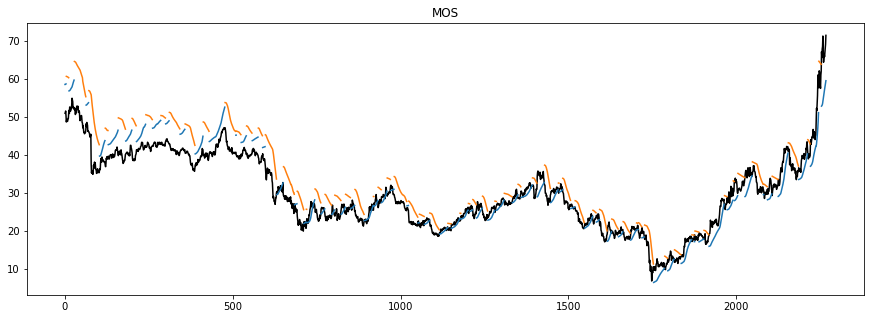

In [33]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker3)
ax.plot(modelPSAR.prices[-len(modelPSAR.indicator):], color='black');
ax.plot(modelPSAR.indicator);

# IMPLEMENTAÇÃO DA ESTRATÉGIA GERAL UTILIZANDO AS 3 PROPOSTAS

### ticker1

In [37]:
modelBollinger = Bollinger()
modelKST = KST()
modelPSAR = PSAR()

print(evaluateHist(modelBollinger, {ticker1: f'{ticker1}.csv'}))
print()
print(evaluateHist(modelKST, {ticker1: f'{ticker1}.csv'}))
print()
print(evaluateHist(modelPSAR, {ticker1: f'{ticker1}.csv'}))

Number of trades: 314
Gross P&L: 11.05
Gross Accumulated return: 0.04%
Gross Average Return: 0.10%
Net P&L: 11.01
Hitting ratio: 64.65%


Number of trades: 135
Gross P&L: -27.28
Gross Accumulated return: -0.22%
Gross Average Return: -0.28%
Net P&L: -27.32
Hitting ratio: 56.30%


Number of trades: 133
Gross P&L: -28.19
Gross Accumulated return: -0.23%
Gross Average Return: -0.25%
Net P&L: -28.23
Hitting ratio: 58.65%



In [38]:
signals_bb = modelBollinger.signals
signals_kst = modelKST.signals
signals_psar = modelPSAR.signals

# print(signals_bb)
# print(signals_kst)
# print(signals_psar)

In [39]:
signals_bb = pd.Series(signals_bb)
signals_kst = pd.Series(signals_kst)
signals_psar = pd.Series(signals_psar)

df_signals = pd.DataFrame({'bb': signals_bb, 'kst': signals_kst, 'psar': signals_psar})
df_signals

,bb,kst,psar
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
2264,0,1,1
2265,0,1,1
2266,0,1,1
2267,0,1,1


In [40]:
print(len(signals_bb))
print(len(signals_kst))
print(len(signals_psar))

2269
2269
2269


In [41]:
df_signals.bb.value_counts()

 0    984
-1    708
 1    577
Name: bb, dtype: int64

In [42]:
df_signals.kst.value_counts()

 1    1115
-1    1102
 0      52
Name: kst, dtype: int64

In [43]:
df_signals.psar.value_counts()

-1    1185
 1    1079
 0       5
Name: psar, dtype: int64

In [44]:
# # Bloco para acessar cada linha do df_signals
# for _, row in df_signals.iterrows():
#     row_bb   = row['bb']
#     row_kst  = row['kst']
#     row_psar = row['psar']

In [48]:
df1['bb_signals'] = df_signals['bb']
df1['kst_signals'] = df_signals['kst']
df1['psar_signals'] = df_signals['psar']
df1

,formatted_date,open,high,low,close,adjclose,volume,bb_signals,kst_signals,psar_signals
0,2013-04-08,117.449997,117.870003,116.650002,117.809998,80.496223,4117400,0,0,0
1,2013-04-09,117.989998,118.870003,117.629997,118.639999,81.063347,4849700,0,0,0
2,2013-04-10,118.889999,119.830002,118.510002,119.639999,81.746620,5452000,0,0,0
3,2013-04-11,119.959999,121.150002,119.519997,120.949997,82.641716,6092300,0,0,0
4,2013-04-12,120.459999,120.900002,119.500000,119.940002,81.951630,6391700,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2264,2022-04-01,162.779999,165.949997,162.330002,164.220001,164.220001,8794800,0,1,1
2265,2022-04-04,165.000000,165.449997,163.000000,164.369995,164.369995,8718600,0,1,1
2266,2022-04-05,165.029999,167.720001,163.100006,163.360001,163.360001,9538200,0,1,1
2267,2022-04-06,164.830002,167.009995,164.330002,164.809998,164.809998,9269000,0,1,1


### ticker2

In [49]:
modelBollinger = Bollinger()
modelKST = KST()
modelPSAR = PSAR()

print(evaluateHist(modelBollinger, {ticker2: f'{ticker2}.csv'}))
print()
print(evaluateHist(modelKST, {ticker2: f'{ticker2}.csv'}))
print()
print(evaluateHist(modelPSAR, {ticker2: f'{ticker2}.csv'}))

Number of trades: 328
Gross P&L: 3.58
Gross Accumulated return: 0.06%
Gross Average Return: -0.12%
Net P&L: 3.57
Hitting ratio: 66.16%


Number of trades: 128
Gross P&L: -32.69
Gross Accumulated return: -1.49%
Gross Average Return: -1.90%
Net P&L: -32.70
Hitting ratio: 54.69%


Number of trades: 130
Gross P&L: -21.57
Gross Accumulated return: -0.95%
Gross Average Return: -1.37%
Net P&L: -21.58
Hitting ratio: 60.77%



In [50]:
signals_bb = modelBollinger.signals
signals_kst = modelKST.signals
signals_psar = modelPSAR.signals

In [51]:
signals_bb = pd.Series(signals_bb)
signals_kst = pd.Series(signals_kst)
signals_psar = pd.Series(signals_psar)

df_signals = pd.DataFrame({'bb': signals_bb, 'kst': signals_kst, 'psar': signals_psar})
df_signals

,bb,kst,psar
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,1
...,...,...,...
2264,0,-1,-1
2265,0,-1,-1
2266,1,-1,-1
2267,1,-1,-1


In [52]:
print(len(signals_bb))
print(len(signals_kst))
print(len(signals_psar))

2269
2269
2269


In [53]:
df_signals.bb.value_counts()

 0    1043
-1     637
 1     589
Name: bb, dtype: int64

In [54]:
df_signals.kst.value_counts()

 1    1158
-1    1059
 0      52
Name: kst, dtype: int64

In [55]:
df_signals.psar.value_counts()

 1    1165
-1    1100
 0       4
Name: psar, dtype: int64

In [56]:
# # Bloco para acessar cada linha do df_signals
# for _, row in df_signals.iterrows():
#     row_bb   = row['bb']
#     row_kst  = row['kst']
#     row_psar = row['psar']

In [57]:
df2['bb_signals'] = df_signals['bb']
df2['kst_signals'] = df_signals['kst']
df2['psar_signals'] = df_signals['psar']
df2

,formatted_date,open,high,low,close,adjclose,volume,bb_signals,kst_signals,psar_signals
0,2013-04-08,32.500000,32.939999,32.419998,32.840000,28.155495,3224800,0,0,0
1,2013-04-09,32.970001,33.599998,32.810001,33.470001,28.695633,3180200,0,0,0
2,2013-04-10,33.540001,33.990002,33.480000,33.910000,29.072863,4784800,0,0,0
3,2013-04-11,33.980000,34.119999,33.740002,33.799999,28.978563,4023000,0,0,0
4,2013-04-12,33.500000,33.570000,32.250000,32.540001,27.898289,6103000,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2264,2022-04-01,25.180000,25.900000,25.170000,25.750000,25.750000,13421900,0,-1,-1
2265,2022-04-04,26.090000,26.400000,25.540001,25.680000,25.680000,15846600,0,-1,-1
2266,2022-04-05,25.809999,26.100000,24.719999,24.799999,24.799999,17598200,1,-1,-1
2267,2022-04-06,25.180000,25.410000,24.270000,24.420000,24.420000,15855600,1,-1,-1


### ticker3

In [58]:
modelBollinger = Bollinger()
modelKST = KST()
modelPSAR = PSAR()

print(evaluateHist(modelBollinger, {ticker3: f'{ticker3}.csv'}))
print()
print(evaluateHist(modelKST, {ticker3: f'{ticker3}.csv'}))
print()
print(evaluateHist(modelPSAR, {ticker3: f'{ticker3}.csv'}))

Number of trades: 309
Gross P&L: -41.28
Gross Accumulated return: -0.44%
Gross Average Return: -0.34%
Net P&L: -41.30
Hitting ratio: 60.52%


Number of trades: 141
Gross P&L: -10.29
Gross Accumulated return: -0.24%
Gross Average Return: -0.53%
Net P&L: -10.31
Hitting ratio: 53.90%


Number of trades: 130
Gross P&L: -12.52
Gross Accumulated return: -0.32%
Gross Average Return: 0.03%
Net P&L: -12.53
Hitting ratio: 59.23%



In [59]:
signals_bb = modelBollinger.signals
signals_kst = modelKST.signals
signals_psar = modelPSAR.signals

In [60]:
signals_bb = pd.Series(signals_bb)
signals_kst = pd.Series(signals_kst)
signals_psar = pd.Series(signals_psar)

df_signals = pd.DataFrame({'bb': signals_bb, 'kst': signals_kst, 'psar': signals_psar})
df_signals

,bb,kst,psar
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
2264,0,1,-1
2265,0,1,-1
2266,0,1,-1
2267,0,1,-1


In [61]:
print(len(signals_bb))
print(len(signals_kst))
print(len(signals_psar))

2269
2269
2269


In [62]:
df_signals.bb.value_counts()

 0    1041
-1     657
 1     571
Name: bb, dtype: int64

In [63]:
df_signals.kst.value_counts()

-1    1129
 1    1088
 0      52
Name: kst, dtype: int64

In [64]:
df_signals.psar.value_counts()

-1    1145
 1    1119
 0       5
Name: psar, dtype: int64

In [65]:
# # Bloco para acessar cada linha do df_signals se necessário
# for _, row in df_signals.iterrows():
#     row_bb   = row['bb']
#     row_kst  = row['kst']
#     row_psar = row['psar']

In [66]:
df3['bb_signals'] = df_signals['bb']
df3['kst_signals'] = df_signals['kst']
df3['psar_signals'] = df_signals['psar']
df3

,formatted_date,open,high,low,close,adjclose,volume,bb_signals,kst_signals,psar_signals
0,2013-04-08,59.200001,59.320000,58.599998,58.919998,50.171288,1477700,0,0,0
1,2013-04-09,59.139999,60.369999,59.139999,59.950001,51.048355,2341300,0,0,0
2,2013-04-10,60.060001,60.599998,59.660000,60.080002,51.159039,2731800,0,0,0
3,2013-04-11,60.080002,60.730000,59.970001,60.610001,51.610352,1869100,0,0,0
4,2013-04-12,60.419998,60.480000,58.799999,59.200001,50.409706,2521700,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2264,2022-04-01,66.370003,68.879997,65.389999,65.879997,65.879997,6539600,0,1,-1
2265,2022-04-04,67.059998,67.459999,65.050003,67.000000,67.000000,5187900,0,1,-1
2266,2022-04-05,67.919998,70.080002,67.230003,67.750000,67.750000,10554200,0,1,-1
2267,2022-04-06,68.070000,72.230003,68.070000,69.190002,69.190002,13999300,0,1,-1
